In [1]:
import pandas as pd
from tqdm import tqdm

## DATAPREP

In [2]:
d1 = pd.read_parquet("data/wikipedia_2025.pq")
d1

,id,revid:,title,url,text
0,5674408,662262,Anna Chandy,https://pt.wikipedia.org/wiki?curid=5674408,"Anna Chandy (1905-1996), também conhecida como..."
1,5674410,321756,Ajahn Mahā Bua,https://pt.wikipedia.org/wiki?curid=5674410,"Ajahn Mahā Bua (Udon Thani, 12 de agosto de 19..."
2,5674413,2702392,Debra Elmegreen,https://pt.wikipedia.org/wiki?curid=5674413,"Debra Meloy Elmegreen (South Bend, Indiana, 23..."
3,5674416,2123556,Laura Ferrarese,https://pt.wikipedia.org/wiki?curid=5674416,Laura Ferrarese é uma pesquisadora em ciência ...
4,5674418,710641,Anna Chandi,https://pt.wikipedia.org/wiki?curid=5674418,
...,...,...,...,...,...
1949914,302397,1082486,The Grifters,https://pt.wikipedia.org/wiki?curid=302397,"The Grifters (""br"": Os Imorais; ""pt"": Anatomia..."
1949915,302398,4468,Calpaínas,https://pt.wikipedia.org/wiki?curid=302398,
1949916,302399,662262,Crystal Planet,https://pt.wikipedia.org/wiki?curid=302399,Crystal Planet é um álbum do guitarrista de ro...
1949917,302400,3288074,Cláudio Paiva,https://pt.wikipedia.org/wiki?curid=302400,"Cláudio Paiva (Niterói, 11 de outubro de 1957)..."


In [3]:
from pathlib import Path

openSub = Path("data/OpenSubtitles.en-pt.pt").read_text(encoding="utf-8").split("\n")
print(openSub[:5])
print(len(openSub))

['Em episódios anteriores...', 'O diretor Mueller atribuiu-nos um caso importante.', 'Oficialmente, a investigação chama-se Amerithrax.', 'Quem enviou as cartas obteve o antraz num laboratório americano.', 'Não estaríamos aqui sem provas que nos levam ao USAMRIID.']
68557862


In [4]:
df = pd.concat([
    d1[['text']],
    pd.DataFrame({'text': openSub})
]).reset_index(drop=True)
df

,text
0,"Anna Chandy (1905-1996), também conhecida como..."
1,"Ajahn Mahā Bua (Udon Thani, 12 de agosto de 19..."
2,"Debra Meloy Elmegreen (South Bend, Indiana, 23..."
3,Laura Ferrarese é uma pesquisadora em ciência ...
4,
...,...
70507776,Ganhei.
70507777,Vou por isto na tua divída.
70507778,Que chatice.
70507779,versão e revisão: nandinho sincronia:


In [5]:
df["len"] = df["text"].apply(len)
df = df[df["len"] >= 15].reset_index(drop=True)
len(df)

52934086

In [6]:
# quebra em paragrafos
paragrafos = []
for r in tqdm(df.itertuples(), total=len(df)):
    texto = r.text
    paragrafos += texto.split("\n")

len(paragrafos)

100%|██████████| 52934086/52934086 [00:32<00:00, 1617878.65it/s]


60637185

In [7]:
print(paragrafos[10])

Depois de ordenado passou a estudar as encarnações de Buda e de seus discípulos Arahants. Declarou que ficou tão impressionado com o que estava estudando que decidiu buscar a mesma iluminação que os discípulos originais de Buda alcançaram. Deste modo, esforçou-se por entender os modos de praticar o Dhamma que, eventualmente, levaria a Nibbana.


In [8]:
# quebra em frases
import re

SENT_SPLIT = re.compile(r"(?<=[\.\!\?])\s+")
def split_sentences(text):
    return SENT_SPLIT.split(text)

frases = []
for p in tqdm(paragrafos):
    frases += split_sentences(p)

print(len(frases))

100%|██████████| 60637185/60637185 [00:55<00:00, 1100305.57it/s]

76771745


In [9]:
df = pd.DataFrame({'text': frases})
df["len"] = df["text"].apply(len)
df

,text,len
0,"Anna Chandy (1905-1996), também conhecida como...",119
1,Chandy foi a primeira mulher a ocupar o cargo ...,141
2,"De fato, foi a primeira mulher juíza em todo o...",108
3,Anna Chandy nasceu em 1905 e foi criada em Tri...,93
4,"Em 1926, após concluir uma pós-graduação, torn...",116
...,...,...
76771740,"Hmmm, passo esta vez.",21
76771741,"Está bem, vejamos.",18
76771742,Royal straight flush.,21
76771743,Vou por isto na tua divída.,27


In [10]:
df["len"].describe().astype(int)

count    76771745
mean           56
std            60
min             0
25%            21
50%            34
75%            66
max          5541
Name: len, dtype: int64

<Axes: >

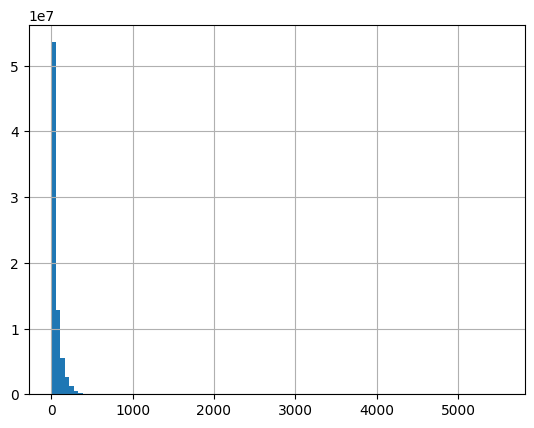

In [11]:
df["len"].hist(bins=100)

In [14]:
# filtro
def filtra_zuado(texto):
    # tamanho
    if len(texto) < 20 or len(texto) > 200:
        return 1
    
    # muitos chaves e colchetes (tags)
    if re.search(r"[=\{\}\[\]\|<>]", texto):
        return 1
    
    # topicos
    if texto.startswith(("*", "|", "•")):
        return 1
    
    # coisas que nao sao letras
    if re.fullmatch(r"[\d\s\W]+", texto):
        return 1
    
    # tem muitas virgulas
    if texto.count(",") > 6:
        return 1
    
    # nao tem letras
    if not re.search(r"[a-zA-ZáéíóúãõçÁÉÍÓÚÃÕÇ]", texto):
        return 1

    # urls
    if re.search(r"http|www|@", texto):
        return 1
    
    # figuras ou tabelas
    if re.search(r"(table|figure|chart|graph|image)", texto.lower()):
        return 1
    
    return 0

In [15]:
df["filtra"] = df.text.apply(filtra_zuado)
df.filtra.value_counts()

filtra
0    57723155
1    19048590
Name: count, dtype: int64

In [16]:
df = df[df.filtra == 0].reset_index(drop=True)
df

,text,len,filtra
0,"Anna Chandy (1905-1996), também conhecida como...",119,0
1,Chandy foi a primeira mulher a ocupar o cargo ...,141,0
2,"De fato, foi a primeira mulher juíza em todo o...",108,0
3,Anna Chandy nasceu em 1905 e foi criada em Tri...,93,0
4,"Em 1926, após concluir uma pós-graduação, torn...",116,0
...,...,...,...
57723150,Não te preocupes com essa coisa.,32,0
57723151,"Hmmm, passo esta vez.",21,0
57723152,Royal straight flush.,21,0
57723153,Vou por isto na tua divída.,27,0


<Axes: >

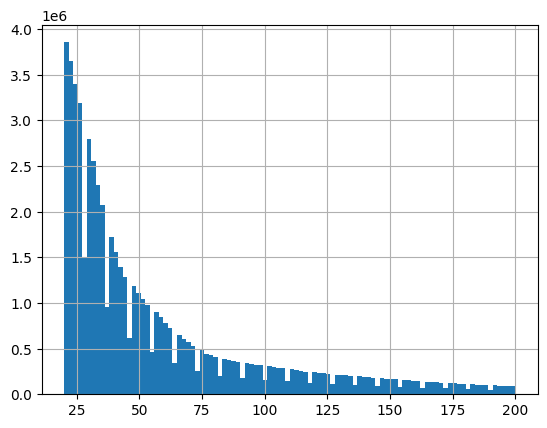

In [17]:
df["len"].hist(bins=100)

In [18]:
# split
split = ["valid" for _ in range(1500)] + ["train" for _ in range(len(df) - 1500)]

df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
df["split"] = split
df

,text,len,filtra,split
0,Eu decidi ficar por aí se precisar de algo.,43,0,valid
1,Não tinha nada que ler...,25,0,valid
2,Apenas estou a tentar ser sincero com o corço ...,53,0,valid
3,Ela está a demorar imenso.,26,0,valid
4,Todos nos temos de nos divorciar dos nossos de...,61,0,valid
...,...,...,...,...
57723150,Grohl quase aceitou uma posição como baterista...,88,0,train
57723151,"- Angela, ouve isto.",20,0,train
57723152,As coisas de que ela gostava.,29,0,train
57723153,"É bom ser próximo, mas às vezes é demais e iss...",65,0,train


In [ ]:
df.to_parquet("data/base_treinamento.pq")

## TOKENIZACAO

In [22]:
df = pd.read_parquet("data/base_treinamento.pq")

In [23]:
vocab = set()
for r in tqdm(df.itertuples(), total=len(df)):
    texto = r.text
    for c in texto:
        vocab.add(c)

print(len(vocab))
vocab

100%|██████████| 57723155/57723155 [02:21<00:00, 407027.13it/s]

8924


{'ễ',
 '刻',
 '謂',
 'Ț',
 '牌',
 'თ',
 '见',
 '𐩺',
 '榊',
 '֣',
 '読',
 'ዒ',
 'ת',
 'ޕ',
 'ʓ',
 '羁',
 '𞠂',
 '绣',
 'ヾ',
 '橫',
 '闻',
 '법',
 '길',
 '២',
 'Ṭ',
 'Վ',
 '鄒',
 'ϒ',
 'ꞑ',
 '贵',
 'ϰ',
 '连',
 'ς',
 'ణ',
 '𐭊',
 '芾',
 '詩',
 '\U000e0063',
 '亲',
 '资',
 '顺',
 'ણ',
 '长',
 'ল',
 '┌',
 'ፊ',
 'ƕ',
 'ɘ',
 '혁',
 'K',
 '投',
 '摑',
 '쩌',
 '崎',
 'ដ',
 'ⲗ',
 '皖',
 '俞',
 '해',
 '\u2003',
 '삐',
 '瑄',
 '滉',
 '蠻',
 '賧',
 '声',
 '担',
 '홀',
 '岐',
 'ೈ',
 '休',
 '\uf0b7',
 '帘',
 'ſ',
 '림',
 '쑤',
 '鲜',
 '舱',
 '﷼',
 '浦',
 '髡',
 '舶',
 '首',
 'ਕ',
 '鞘',
 '𐡅',
 '圈',
 'ង',
 '硬',
 '醤',
 '干',
 '랜',
 'ủ',
 'ा',
 'ἀ',
 '裔',
 'ყ',
 '燚',
 '凱',
 '轻',
 'ዋ',
 '幹',
 '빤',
 'ܰ',
 'ᡕ',
 '脫',
 'ଞ',
 '濵',
 '弾',
 '庆',
 '舘',
 '𐐻',
 '应',
 'ཇ',
 'ް',
 '🏳',
 'け',
 '倫',
 '孺',
 '페',
 'Ͳ',
 'ਘ',
 '蹟',
 '께',
 'ӷ',
 '鄱',
 '刈',
 'Ⴇ',
 '兽',
 '烊',
 '端',
 'ė',
 'ȃ',
 '圳',
 '/',
 '→',
 '막',
 '鑫',
 '폈',
 '尧',
 'ั',
 '弗',
 '弹',
 'ં',
 '⇌',
 '覆',
 '믿',
 '₀',
 '𐩡',
 'ओ',
 '♠',
 '限',
 'ֿ',
 '₈',
 '穂',
 '讐',
 'ທ',
 '麩',
 '③',
 '毋',
 'პ',
 '두',
 '银',
 '젊

In [24]:
CHAR_PERMITIDOS = "aáàâãbcçdeéêfghiíjklmnoóõôpqrstuúvwxyz1234567890!:?.,;'()[]-$% " + '"'
VOCAB_PERMITIDO = set()
for char in CHAR_PERMITIDOS:
    VOCAB_PERMITIDO.add(char)
    VOCAB_PERMITIDO.add(char.upper())

def filtra_vocab(texto):
    for c in texto:
        if c not in VOCAB_PERMITIDO:
            return 1
    return 0

df["filtra"] = df.text.apply(filtra_vocab)
df.filtra.value_counts()

filtra
0    56042411
1     1680744
Name: count, dtype: int64

In [25]:
df = df[df.filtra == 0].reset_index(drop=True)
df.split.value_counts()

split
train    56040952
valid        1459
Name: count, dtype: int64

In [26]:
vocab = set()
for r in tqdm(df.itertuples(), total=len(df)):
    texto = r.text
    for c in texto:
        vocab.add(c)

print(len(vocab))
vocab

100%|██████████| 56042411/56042411 [02:15<00:00, 412257.96it/s]

100


{' ',
 '!',
 '"',
 '$',
 '%',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'À',
 'Á',
 'Â',
 'Ã',
 'Ç',
 'É',
 'Ê',
 'Í',
 'Ó',
 'Ô',
 'Õ',
 'Ú',
 'à',
 'á',
 'â',
 'ã',
 'ç',
 'é',
 'ê',
 'í',
 'ó',
 'ô',
 'õ',
 'ú'}

In [27]:
tokenize_dict = {char: i for i, char in enumerate(vocab)}
detokenize_dict = {i: char for char, i in tokenize_dict.items()}

print(tokenize_dict)

{'O': 0, 'v': 1, '2': 2, '5': 3, 'h': 4, 'D': 5, 'Ã': 6, 'Ú': 7, 'u': 8, '!': 9, 'R': 10, 'E': 11, 'z': 12, 'g': 13, 'Õ': 14, ':': 15, 'A': 16, '?': 17, 'x': 18, 'I': 19, 'C': 20, 'í': 21, 'Z': 22, 'ô': 23, ' ': 24, 'À': 25, '8': 26, 'é': 27, '$': 28, ';': 29, '"': 30, 'ú': 31, 'ê': 32, 'p': 33, 'J': 34, 'Ê': 35, 'F': 36, '.': 37, 'É': 38, 'Q': 39, '%': 40, 'K': 41, 'c': 42, 'k': 43, 'Í': 44, '3': 45, 'Y': 46, 'Â': 47, 's': 48, 'õ': 49, 'U': 50, '9': 51, 'l': 52, 'j': 53, 'b': 54, 'M': 55, ',': 56, 'y': 57, '6': 58, '(': 59, 'n': 60, '-': 61, 'P': 62, 'i': 63, 'G': 64, '7': 65, 'X': 66, 'm': 67, '1': 68, 'e': 69, 'w': 70, 'q': 71, 'd': 72, 'à': 73, 'o': 74, 'B': 75, 'V': 76, 'ã': 77, '4': 78, 'ç': 79, 'ó': 80, '0': 81, 'á': 82, 'f': 83, 'Ô': 84, 'T': 85, 'N': 86, 'Ó': 87, 'a': 88, 'W': 89, 'â': 90, 'H': 91, 'L': 92, 'S': 93, ')': 94, 'Á': 95, 't': 96, 'Ç': 97, "'": 98, 'r': 99}


In [28]:
import json

Path("artifacts/tokenize_dict.json").write_text(json.dumps(tokenize_dict), encoding="utf-8")
Path("artifacts/detokenize_dict.json").write_text(json.dumps(detokenize_dict), encoding="utf-8")

1211

In [29]:
df.to_parquet("data/base_treinamento.pq")